In [2]:
import tensorflow as tf
import tensorflow_datasets as tfd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense,Flatten,Conv2D,MaxPooling2D,InputLayer,BatchNormalization
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [ ]:
dataset, dataset_info = tfd.load('malaria',with_info=True,as_supervised=True,shuffle_files=True,split=['train'])

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

In [4]:
dataset_info

tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_dir=PosixGPath('/tmp/tmpig1l1f8otfds'),
    file_format=tfrecord,
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward
      improved malaria parasite detection in thin blood smear images},


In [5]:
for data in dataset[0].take(1):
    print(data)

(<tf.Tensor: shape=(151, 115, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)>, <tf.Tensor: shape=(), dtype=int64, numpy=1>)


In [6]:
def split(dataset,train_ratio,val_ratio,test_ratio):
  size=len(dataset)
  train_dataset=dataset.take(int(size*train_ratio))
  val_dataset=dataset.skip(int(size*train_ratio)).take(int(size*val_ratio))
  test_dataset=dataset.skip(int(size*train_ratio)+int(size*val_ratio))

  return train_dataset,val_dataset,test_dataset

In [7]:
TRAIN_RATIO=0.7
VAL_RATIO=0.15
TEST_RATIO=0.15

train_dataset,val_dataset,test_dataset=split(dataset[0],TRAIN_RATIO,VAL_RATIO,TEST_RATIO)

# ***Dataset visualization***

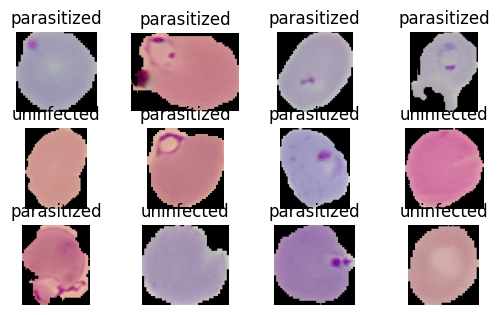

In [8]:
for i,(image,label) in enumerate(train_dataset.take(12)):
  ax=plt.subplot(4,4,i+1)
  plt.imshow(image)
  plt.title(dataset_info.features['label'].int2str(label))
  plt.axis('off')


# ***Data Preprocessing***

In [9]:
def resize (image,label):
  return tf.image.resize(image,(224,224)),label

In [10]:
train_dataset=train_dataset.map(resize)
val_dataset=val_dataset.map(resize)
test_dataset=test_dataset.map(resize)

In [11]:
train_dataset= train_dataset.shuffle(buffer_size=8,reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset= val_dataset.shuffle(buffer_size=8,reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)

In [12]:
#Lenet architcure
model = tf.keras.Sequential([
    InputLayer(input_shape=(224,224,3)),
    Conv2D(filters=6 , kernel_size=5 ,strides= 1,padding= 'valid',activation='sigmoid'),
    BatchNormalization(),
    MaxPooling2D(pool_size=2,strides=2),
    Conv2D(filters=16 , kernel_size=5 ,strides= 1,padding= 'valid',activation='sigmoid'),
    BatchNormalization(),
    MaxPooling2D(pool_size=2,strides=2),
    Flatten(),
    Dense(100 , activation='sigmoid'),
    BatchNormalization(),
    Dense(10 , activation='sigmoid'),
    BatchNormalization(),
    Dense(1 , activation='sigmoid')
])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 220, 220, 6)         │             456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 220, 220, 6)         │              24 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 110, 110, 6)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 106, 106, 16)        │           2,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 106, 106, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 53, 53, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 44944)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 100)                 │       4,494,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 100)                 │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,010 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 10)                  │              40 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,498,921 (17.16 MB)

 Trainable params: 4,498,657 (17.16 MB)

 Non-trainable params: 264 (1.03 KB)

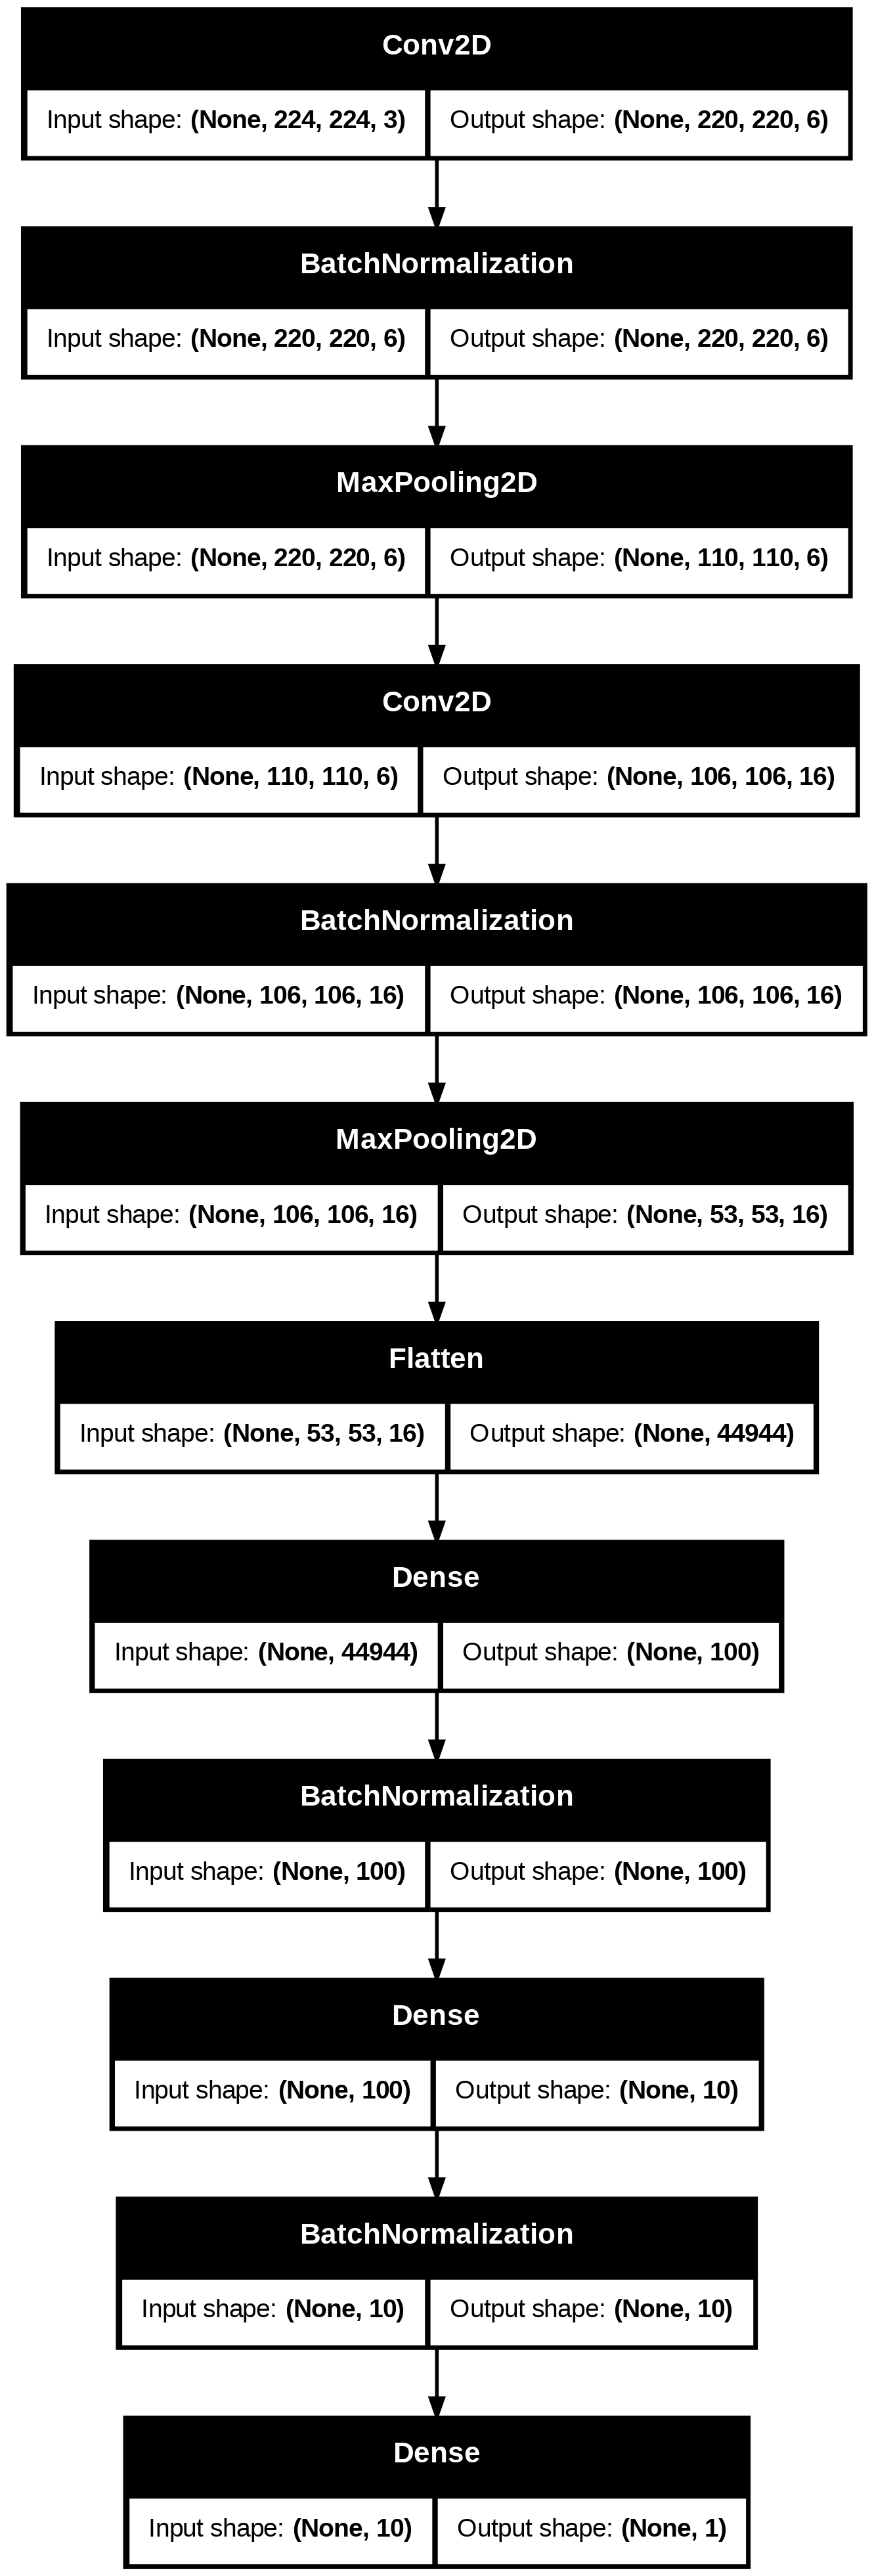

In [13]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [14]:
model.compile(
    optimizer=Adam(learning_rate=0.1),
    loss=BinaryCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [15]:
history = model.fit(train_dataset,epochs=50,validation_data=val_dataset,verbose=1)

Epoch 1/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 76s 109ms/step - accuracy: 0.4980 - loss: 0.7032 - val_accuracy: 0.4987 - val_loss: 0.6997
Epoch 2/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 53s 87ms/step - accuracy: 0.5037 - loss: 0.6955 - val_accuracy: 0.5016 - val_loss: 0.6936
Epoch 3/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 50s 83ms/step - accuracy: 0.5053 - loss: 0.6970 - val_accuracy: 0.4994 - val_loss: 0.8016
Epoch 4/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 77s 75ms/step - accuracy: 0.4990 - loss: 0.6971 - val_accuracy: 0.4984 - val_loss: 0.7035
Epoch 5/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 44s 73ms/step - accuracy: 0.4934 - loss: 0.6984 - val_accuracy: 0.4987 - val_loss: 0.6952
Epoch 6/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 44s 73ms/step - accuracy: 0.4955 - loss: 0.6968 - val_accuracy: 0.5023 - val_loss: 0.7479
Epoch 7/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 43s 72ms/step - accuracy: 0.4925 - loss: 0.7009 - val_accuracy: 0.4977 - val_loss: 0.6955
Epoch 8/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 45s 75ms/step - accuracy: 0.4929 - loss: 0.7023 -

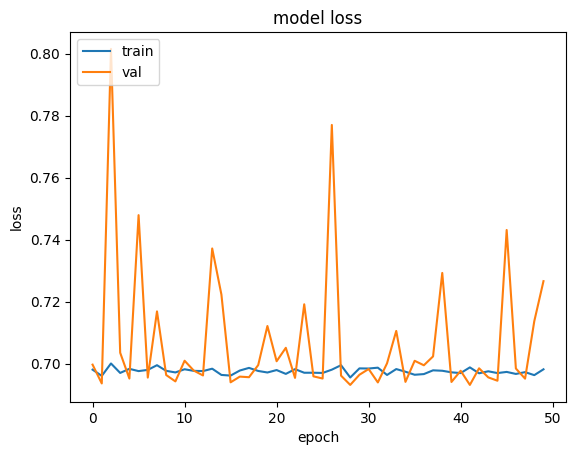

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

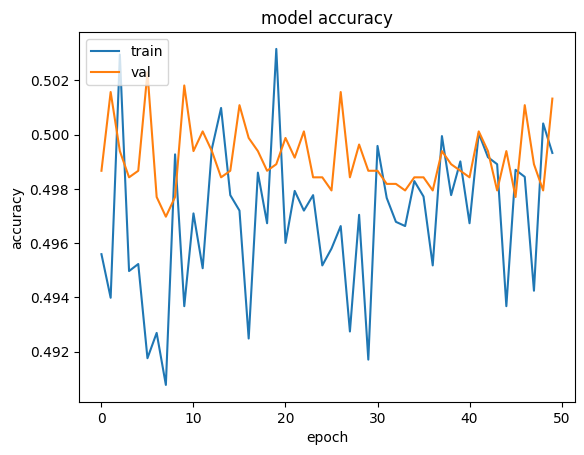

In [17]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [18]:
test_dataset=test_dataset.batch(1)

In [19]:
model.evaluate(test_dataset)

4135/4135 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - accuracy: 0.5116 - loss: 0.7055


[0.71158367395401, 0.5010882616043091]

In [20]:
def get_tested(x):
  return "P" if x<0.5 else "U"


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


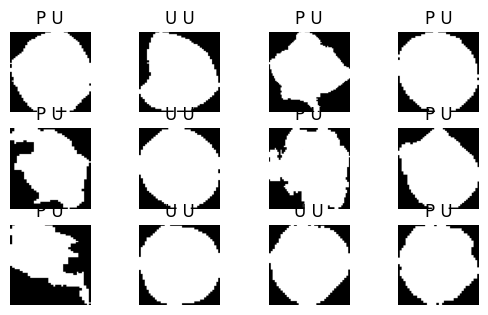

In [21]:
for i, (image,label) in enumerate(test_dataset.take(12)):
  ax=plt.subplot(4,4,i+1)
  plt.imshow(image[0])
  plt.title(str(get_tested(label.numpy()[0]))+" "+str(get_tested(model.predict(image)[0][0])))
  plt.axis('off')